In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import patsy
from patsy.contrasts import Sum
from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,QuadraticDiscriminantAnalysis as QDA)
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML




            Year  Lag1  Lag2  Lag3  Lag4  Lag5    Volume  Today
Year    1.000000   NaN   NaN   NaN   NaN   NaN  0.539006    NaN
Lag1         NaN   1.0   NaN   NaN   NaN   NaN       NaN    NaN
Lag2         NaN   NaN   1.0   NaN   NaN   NaN       NaN    NaN
Lag3         NaN   NaN   NaN   1.0   NaN   NaN       NaN    NaN
Lag4         NaN   NaN   NaN   NaN   1.0   NaN       NaN    NaN
Lag5         NaN   NaN   NaN   NaN   NaN   1.0       NaN    NaN
Volume  0.539006   NaN   NaN   NaN   NaN   NaN  1.000000    NaN
Today        NaN   NaN   NaN   NaN   NaN   NaN       NaN    1.0


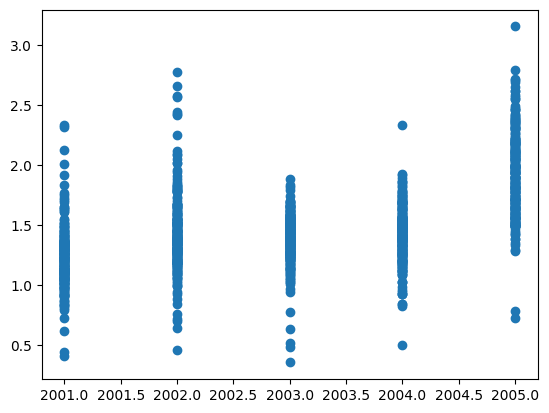

Help on method from_formula in module statsmodels.base.model:

from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs) class method of statsmodels.discrete.discrete_model.Logit
    Create a Model from a formula and dataframe.
    
    Parameters
    ----------
    formula : str or generic Formula object
        The formula specifying the model.
    data : array_like
        The data for the model. See Notes.
    subset : array_like
        An array-like object of booleans, integers, or index values that
        indicate the subset of df to use in the model. Assumes df is a
        `pandas.DataFrame`.
    drop_cols : array_like
        Columns to drop from the design matrix.  Cannot be used to
        drop terms involving categoricals.
    *args
        Additional positional argument that are passed to the model.
    **kwargs
        These are passed to the model with one exception. The
        ``eval_env`` keyword is passed to patsy. It can be either a
        :class:

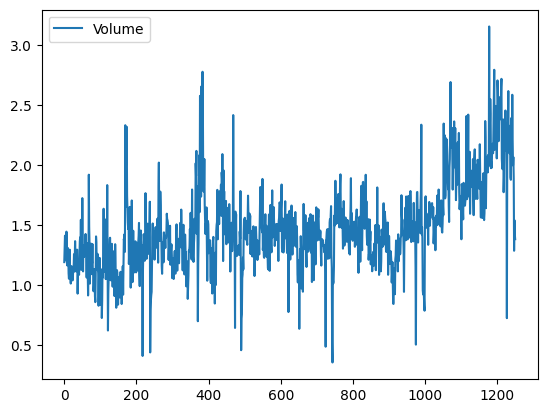

In [250]:
market = load_data('Smarket')
market.columns
smarket=market.drop('Direction', axis=1)
correlation=smarket.corr()
print(correlation[correlation>0.5])
plt.scatter( market['Year'],market['Volume'])
plt.show()
smarket.plot(y='Volume')
print(help(smf.logit))

In [251]:
print(market.columns)
x= market.drop(['Direction','Today','Year'], axis=1)
y= market['Direction'].map({'Up': 1,'Down':0})
y= y.astype(int)
df = pd.concat([x,y],axis=1)
df= pd.DataFrame(df)

formula = 'Direction ~ '+' + '.join(x.columns)
print(formula)


logit1= smf.logit(formula, data=df).fit()
x=sm.add_constant(x)
logit2= sm.GLM(y,x, family=sm.families.Binomial()).fit()
# print(logit1.summary(),logit2.summary())
# f no data set is supplied to the predict() function, then the probabilities 
# are computed for the train-ing data that was used to fit the logistic regression model.
probs=logit2.get_prediction(x).summary_frame(0.05)
# print(probs)
probs['direction_pred']=np.where(probs['mean']>0.5,1,0)
probs['direction_pred'].astype(int)
# confusion matrix(actual, predicted)
confusion_matrix= pd.crosstab(market['Direction'],probs['direction_pred'])
print(confusion_matrix.T)
np.mean(y == probs['direction_pred'])


Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')
Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume
Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
Direction       Down   Up
direction_pred           
0                145  141
1                457  507


0.5216

In [252]:
# Split the data into training and testing sets

test_data1= np.where(market['Year'] >= 2005)[0]

test_data1.shape
type(test_data1)
market.index
# this approcah works for 1D array
market.iloc[test_data1].head()

# ~ only works for boolean data or numerical data
# test_data = market.iloc[~train_data]
# print(test_data.head())


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
998,2005,-0.134,0.008,-0.007,0.715,-0.431,0.7869,-0.812,Down
999,2005,-0.812,-0.134,0.008,-0.007,0.715,1.5108,-1.167,Down
1000,2005,-1.167,-0.812,-0.134,0.008,-0.007,1.7210,-0.363,Down
1001,2005,-0.363,-1.167,-0.812,-0.134,0.008,1.7389,0.351,Up
1002,2005,0.351,-0.363,-1.167,-0.812,-0.134,1.5691,-0.143,Down


In [253]:
# splitting the data into training and testing sets
df['Year'] = market['Year']
print(df)

train_data= df[df['Year'] < 2005]
test_data= df[df['Year'] >= 2005]

train_y, train_x = train_data['Direction'], train_data.drop(['Direction','Year'], axis=1)
test_y, test_x = test_data['Direction'], test_data.drop(['Direction','Year'], axis=1)

# fitting the model
logit3 = smf.logit(formula, data=train_data).fit()
logit3.summary()

# predicting the test data
pred2=logit3.predict(test_x)
pred2['dir']= np.where(pred2>0.5,1,0)
# confusion matrix
confusion_matrix2 = pd.crosstab(test_y, pred2['dir']).T
print(confusion_matrix2)
true_pred, false_pred = np.mean(test_y==pred2['dir']), np.mean(test_y!=pred2['dir'])
display(HTML("<h3 style='color:red;'>true_pred &nbsp;&nbsp;&nbsp;&nbsp; false_pred</h3>"))

print(true_pred, false_pred)

# fitting with lag 1 and lag 2 only
logit4= smf.logit('Direction~Lag1+Lag2',data=train_data).fit()
prob_pred2=logit4.predict(test_x)
prob_pred2=np.where(prob_pred2>0.5,1,0)

# confusion_mat3
confusion_mat3= pd.crosstab(test_y,prob_pred2).T
print(confusion_mat3)

# true_pred and false_pred
true_pred2 = np.sum([confusion_mat3[0][0], confusion_mat3[1][1]])/np.sum(confusion_mat3.values)
false_pred2 = np.sum([confusion_mat3[0][1], confusion_mat3[1][0]])/np.sum(confusion_mat3.values)
print(true_pred2, false_pred2)

# true_pred2, false_pred2= np.mean(confusion_mat3[0][0],confusion_mat3[1][1]),np.mean(confusion_mat3[0][1],confusion_mat3[0][1])


       Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Direction  Year
0     0.381 -0.192 -2.624 -1.055  5.010  1.19130          1  2001
1     0.959  0.381 -0.192 -2.624 -1.055  1.29650          1  2001
2     1.032  0.959  0.381 -0.192 -2.624  1.41120          0  2001
3    -0.623  1.032  0.959  0.381 -0.192  1.27600          1  2001
4     0.614 -0.623  1.032  0.959  0.381  1.20570          1  2001
...     ...    ...    ...    ...    ...      ...        ...   ...
1245  0.422  0.252 -0.024 -0.584 -0.285  1.88850          1  2005
1246  0.043  0.422  0.252 -0.024 -0.584  1.28581          0  2005
1247 -0.955  0.043  0.422  0.252 -0.024  1.54047          1  2005
1248  0.130 -0.955  0.043  0.422  0.252  1.42236          0  2005
1249 -0.298  0.130 -0.955  0.043  0.422  1.38254          0  2005

[1250 rows x 8 columns]
Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
Direction   0   1
col_0            
0          77  97
1          34  44


0.4801587301587302 0.5198412698412699
Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3
Direction   0    1
col_0             
0          35   35
1          76  106
0.5595238095238095 0.44047619047619047


In [254]:
# lda
# help(LDA)
lda=LDA(store_covariance=True)
lda.fit(train_x[['Lag1','Lag2']], train_y)
print(lda.means_)
print(lda.classes_)
lda.priors_
train_x.columns
lda.scalings_
predict_proba=lda.predict_proba(test_x[['Lag1','Lag2']])
predict_lda=lda.predict(test_x[['Lag1','Lag2']])
print(predict_lda)
# confusion matrix
confusion_matrix_lda= pd.crosstab(test_y, predict_lda).T
print(confusion_matrix_lda)
# setting threshold to 0.0
predict_proba.shape
predict_proba_6= np.where(predict_proba[:,1]>0.9,1,0)
predict_proba_6.sum()


[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[0 1]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1
 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1
 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1]
Direction   0    1
col_0             
0          35   35
1          76  106


0

In [255]:
# quadratic discrimant analysis
qda = QDA(store_covariance=True)
qda.fit(train_x[['Lag1','Lag2']], train_y)
print(qda.means_)
qda.priors_
qda.covariance_[0]
qda_predict=qda.predict(test_x[['Lag1','Lag2']])
print(qda_predict)
confusion_mat4=pd.crosstab(test_y,qda_predict).T
print(confusion_mat4)
true_pred3 = np.sum(np.diag(confusion_mat4.values))/(np.sum(confusion_mat4.values))
true_pred3
qda.scalings_

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1
 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 1
 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Direction   0    1
col_0             
0          30   20
1          81  121


[array([1.56294495, 1.47927279]), array([1.53455065, 1.47272326])]

In [256]:
# naive bayes
nb= GaussianNB()
nb.fit(train_x[['Lag1','Lag2']], train_y)
nb.classes_
nb.class_prior_
# nb.theta_ = mean of each class
print(nb.theta_)
print(nb.var_)
indexofy=train_y.loc[train_y==0]
print(train_x.loc[indexofy,['Lag1','Lag2']].mean())

print(type(indexofy))

pred_nb=nb.predict(test_x[['Lag1','Lag2']])
# confusion_matrix
confusion_matrix_nb=pd.crosstab(test_y,pred_nb).T
confusion_matrix_nb

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]
[[1.50355429 1.53246749]
 [1.51401364 1.48732877]]
Lag1    0.381
Lag2   -0.192
dtype: float64
<class 'pandas.core.series.Series'>


Direction,0,1
col_0,,
0,29,20
1,82,121


In [257]:
# knearest classifier
knn= KNeighborsClassifier(n_neighbors=3)
train_x1= train_x[['Lag1','Lag2']]
knn.fit(train_x1, train_y)
pred_knn=knn.predict(test_x[['Lag1','Lag2']])
# confusion matrix
confusion_matrix_knn=pd.crosstab(test_y,pred_knn).T
print(confusion_matrix_knn)
true_pred_knn= np.sum(np.diag(confusion_matrix_knn.values))/(np.sum(confusion_matrix_knn.values))
true_pred_knn

Direction   0   1
col_0            
0          48  55
1          63  86


0.5317460317460317

In [258]:
# k nearest neighbours on caravan dataset

caravan=load_data('Caravan')
caravan.columns
caravan['Purchase'].value_counts()
feature= caravan.drop(['Purchase'], axis=1)
scaler = StandardScaler(with_mean=True, with_std=True,copy=True)
scaler.fit(feature)
scaled_feature=scaler.transform(feature)
scaled_feature.var(axis=0)
scaled_feature.mean(axis=1)
# train_test_split
(traink_x,testk_x,traink_y,testk_y)= train_test_split(scaled_feature,caravan['Purchase'],test_size=1000,random_state=0 )
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(traink_x,traink_y)
pred_knn1=knn1.predict(testk_x)
# confusion matrix
confusion_matrix_knn1=pd.crosstab(testk_y,pred_knn1).T
print(confusion_matrix_knn1)
# error rate
error_rate=np.mean(testk_y!=pred_knn1)
correct_rate=1-error_rate
print(error_rate,correct_rate)


Purchase   No  Yes
col_0             
No        880   58
Yes        53    9
0.111 0.889


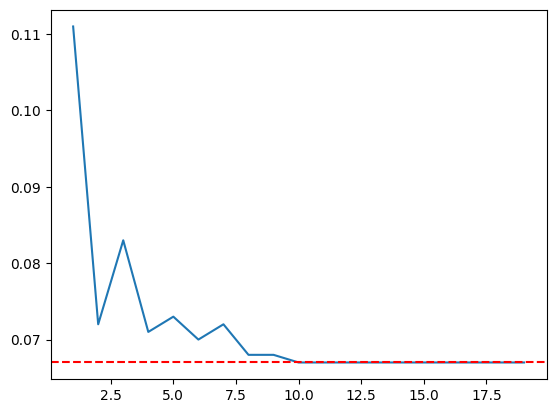

In [259]:
# tuning parameters
A=[]
B=[]
for k in range(1,20):
    scaler.fit(traink_x)
    scaled_feature2= scaler.transform(traink_x)
    knn2 = KNeighborsClassifier(n_neighbors=k)
    knn2.fit(scaled_feature2,traink_y)
    pred_knn2=knn2.predict(testk_x)
    error_rate=np.mean(testk_y!=pred_knn2)
    correct_rate=1-error_rate
    B.append(correct_rate)
    A.append(error_rate)
plt.plot(range(1,20),A);  
plt.axhline(min(A) , color='r', linestyle='dashed')


In [260]:
# comparison to logistic regression
# LogisticRegression from sklearn.linear_model
logit5 = LogisticRegression(C=1e9, solver='liblinear')
# help(LogisticRegression)
logit5.fit(traink_x,traink_y)
pred_logit=logit5.predict_proba(testk_x)
# print(pred_logit)
logit_labels = np.where( pred_logit [: ,1] > 0.25 , 'Yes ', 'No')
# print(type(logit_labels))
# confusion matrix
confusion_matrix_logit5=pd.crosstab(logit_labels,testk_y).T
print(confusion_matrix_logit5)

row_0      No  Yes 
Purchase           
No        913    20
Yes        58     9


In [261]:
# linear regression
bike = load_data('Bikeshare')
print(bike.columns)
bike.dtypes
feat=bike[['mnth','hr','workingday','temp','weathersit']]
res=bike['bikers']
# a is x more than the baseline variable
formula='bikers~'+'+'.join(feat.columns)
# sum encoding or effect encoding(default baseline is chosen as the last category) )
formula2 = 'bikers ~ C(mnth,Sum) + C(hr, Sum) + workingday + temp + weathersit'
data=pd.concat([feat,res],axis=1)
print(data.columns)
linear_model= smf.ols(formula, data=data).fit()
linear_model2=smf.ols(formula2, data=data).fit()    
linear_model.summary()
linear_model2.summary()
a=linear_model.fittedvalues
b=linear_model2.fittedvalues
c=np.sum((a-b)**2)
c
# whether the two values are equal within a tolerance level
np.allclose(a,b)

# filtering parameters by using 'like' argument
d=linear_model2.params.filter(like='mnth')
d=d.reset_index()
d['index']=d['index'].astype(str)
# should use 0 instead of [0] because 0 is a value instead of a string
# old name ---> new namw
d=d.rename({'index':'month',0:'value'}, axis=1)  
print(d.columns)
df3=pd.DataFrame({'month':'C(mnth, Sum[S.Dec]','value': [np.sum(-d['value'])]}) 
df4= pd.concat([d,df3],axis=0)
# r --> using \to escape special character like .,[].{} which means if we use \preceding any special character we are not considering it special character
# (\w+) is the capturing grp
df4['month'] = df4['month'].str.extract(r'\[S\.(\w+)\]')
df4=df4.reset_index(drop=True)
print(df4)

# poisson regression
poiss= smf.poisson(formula2, data=data).fit()
e=poiss.params.filter(like='mnth')
e=e.reset_index()
# mentioning axis is very imp
e=e.rename({'index':'month',0:'value'},axis=1)
df5=pd.DataFrame({'month':'C(mnth, Sum)[S.Dec]','value': [np.sum(-e['value'])]}) 
df6=pd.concat([e,df5],axis=0)
df6['month']=df6['month'].str[15:18]
df6.reset_index(drop=True)



Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'bikers'],
      dtype='object')
Index(['mnth', 'hr', 'workingday', 'temp', 'weathersit', 'bikers'], dtype='object')
Index(['month', 'value'], dtype='object')
    month      value
0     Jan -46.087090
1     Feb -39.241888
2   March -29.535652
3   April  -4.662183
4     May  26.469993
5    June  21.731658
6    July  -0.762630
7     Aug   7.155950
8    Sept  20.591186
9     Oct  29.747162
10    Nov  14.222913
11    Dec   0.370582
Optimization terminated successfully.
         Current function value: 16.256725
         Iterations 9


,month,value
0,Jan,-0.670170
1,Feb,-0.444124
2,Mar,-0.293733
3,Apr,0.021523
4,May,0.240471
5,Jun,0.223235
6,Jul,0.103617
7,Aug,0.151171
8,Sep,0.233493
9,Oct,0.267573


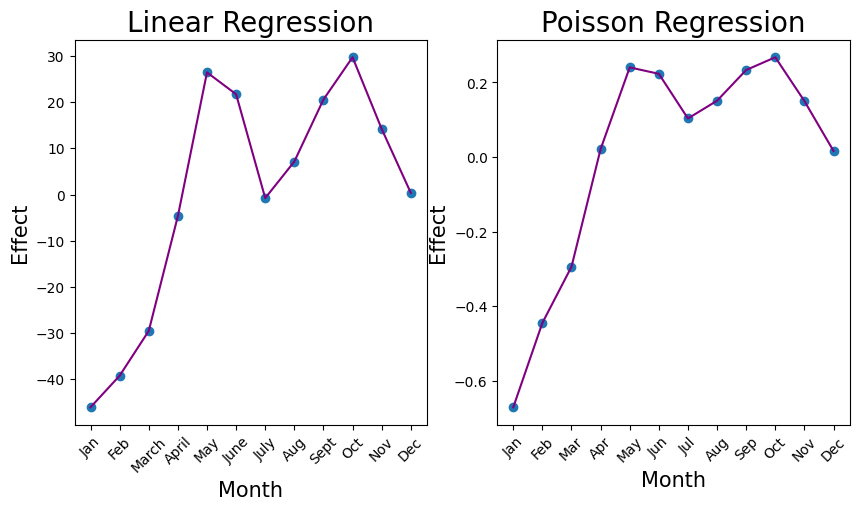

In [262]:


# linear vs poisson
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df4['month'],df4['value'])
ax[0].plot(df4['month'],df4['value'],color='purple')
ax[0].set_title('Linear Regression',fontsize=20)
ax[0].set_xlabel('Month',fontsize=15)
ax[0].set_ylabel('Effect',fontsize=15)
ax[0].set_xticks(df4['month'])
ax[0].set_xticklabels(df4['month'], rotation=45)

ax[1].scatter(df6['month'],df6['value'])
ax[1].plot(df6['month'],df6['value'],color='purple')
ax[1].set_title('Poisson Regression',fontsize=20)
ax[1].set_xlabel('Month',fontsize=15)
ax[1].set_ylabel('Effect',fontsize=15)
ax[1].set_xticks(df6['month'])
ax[1].set_xticklabels(df6['month'], rotation=45)
plt.show()